In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:

# 데이터 로드
actions = ['cold', 'hot']
seq_length = 30

data = np.concatenate([
    np.load('/Users/ihogyun/mediapipe_좌표/seq_hot_1723286660.npy'),
    np.load('/Users/ihogyun/mediapipe_좌표/seq_cold_1723286660.npy'),
], axis=0)

data.shape

(837, 30, 135)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(837, 30, 134)
(837,)


In [9]:
from tensorflow.keras.utils import to_categorical
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(837, 2)

In [10]:

from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=524)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(753, 30, 134) (753, 2)
(84, 30, 134) (84, 2)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

/Users/ihogyun/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        50,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,090 (207.38 KB)

 Trainable params: 53,090 (207.38 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('/Users/ihogyun/models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)



Epoch 1/50
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5399 - loss: 4.2577
Epoch 1: val_acc improved from -inf to 0.58333, saving model to /Users/ihogyun/models/model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.5329 - loss: 4.1598 - val_acc: 0.5833 - val_loss: 1.5867 - learning_rate: 0.0010
Epoch 2/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5621 - loss: 1.9959
Epoch 2: val_acc did not improve from 0.58333
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5615 - loss: 1.9917 - val_acc: 0.5476 - val_loss: 2.2986 - learning_rate: 0.0010
Epoch 3/50
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5446 - loss: 2.5294
Epoch 3: val_acc did not improve from 0.58333
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5457 - loss: 2.4781 - val_acc: 0.5000 - val_loss: 2.2031 - learning_rate: 0.0010
Epoch 4/50
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.6118 - loss: 1.6841
Epoch 4: val_acc improved from 0.58333 to 0.60714, saving model to /Users/ihogyun/models/model.keras
24/2

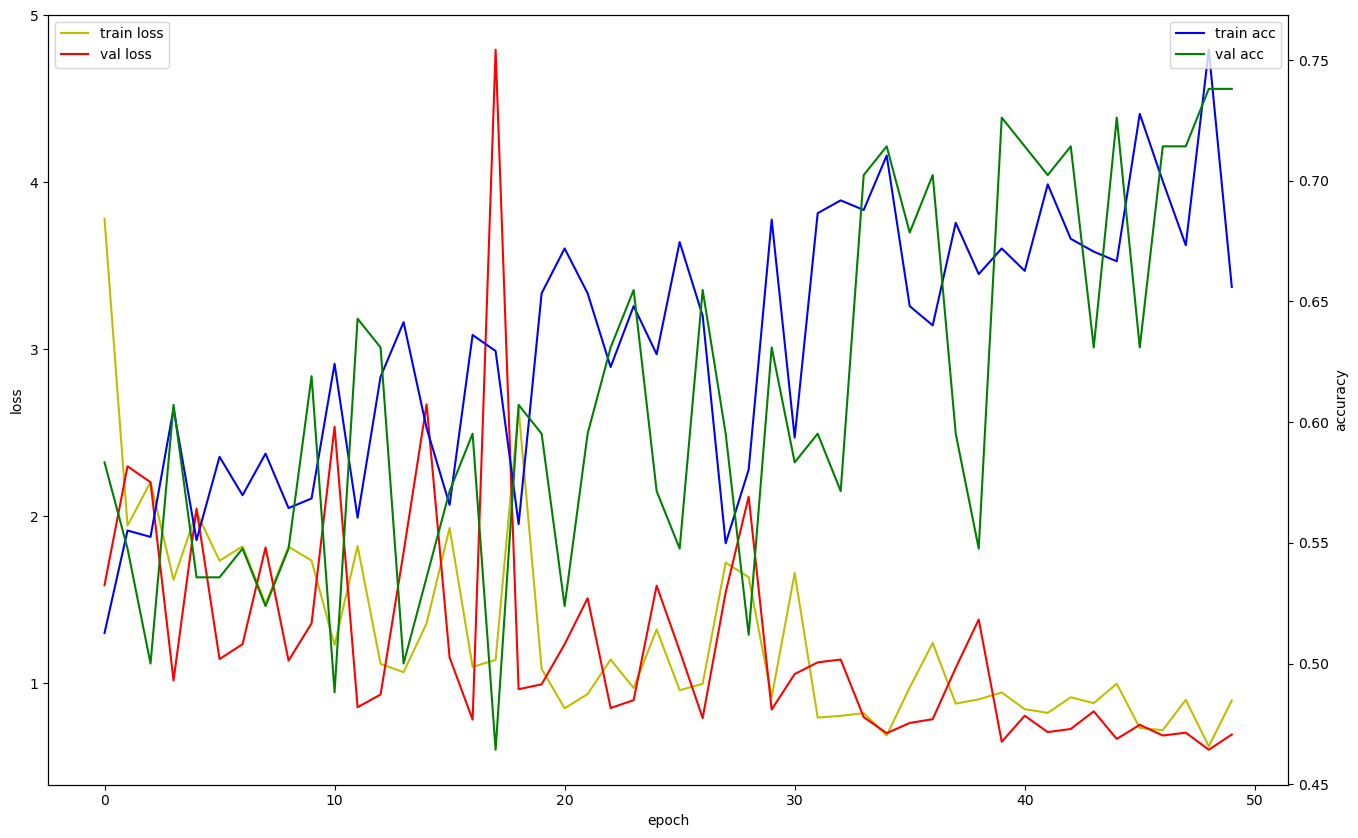

In [19]:
import matplotlib.pyplot as plt

# 손실(loss)과 정확도(accuracy) 그래프 그리기
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

# 학습 손실과 검증 손실 그래프
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

# 학습 정확도와 검증 정확도 그래프
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()


In [21]:
model.save('/Users/ihogyun/models/final_model.keras')